In [140]:
from __future__ import absolute_import, division, print_function

In [141]:
import os
import json
import pandas as pd
import glob
import numpy as np
import sys
import time
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt

## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

%matplotlib inline


# Run clustering

Run clustering on data pre-selected by subject.

## Get data from SQL database

In [142]:
# Set db name
dbname = 'flickr_db'
# Create engine
engine = create_engine('postgresql://@localhost/%s'%(dbname))
# Connect to an  database
conn = psycopg2.connect("dbname="+dbname)
# Open a cursor to perform database operations
cur = conn.cursor()

OperationalError: could not connect to server: No such file or directory
	Is the server running locally and accepting
	connections on Unix domain socket "/tmp/.s.PGSQL.5432"?


In [4]:
# Read data into dataframe
start_time = time.time()
# set query string
sql_query = """
SELECT 
    id,longitude,latitude,title,tags,dateupload,datetaken,title_tags 
FROM 
    flickr_all 
"""
# Run query and save in DF
flickr_all_clean = pd.read_sql_query(sql_query,conn)
print("--- %s seconds ---" % (time.time() - start_time))


--- 51.1435189247 seconds ---


In [5]:
# Close communication with the database
cur.close()
conn.close()


In [6]:
# Save to pickle
flickr_all_clean.to_pickle(os.path.join('..','..','data','flickr_all_clean.df'))

# Alternative: get from pickle

(does not require running postgres server)

In [169]:
# import pre-selected and pickled dataframe
start_time = time.time()
flickr_all_clean = pd.read_pickle(os.path.join('..','..','data','flickr_all_clean.df'))
print("--- %s seconds ---" % (time.time() - start_time))


--- 35.7859909534 seconds ---


In [170]:
flickr_all_clean.shape

(4915904, 8)

## Select subset of data

In [171]:
keyword = 'dog'

In [172]:
# Select subset based on keyword
start_time = time.time()
flickr_all_clean_dogs = flickr_all_clean[flickr_all_clean['title_tags'].str.contains(keyword, na=False)]
print("--- %s seconds ---" % (time.time() - start_time))


--- 4.14104390144 seconds ---


In [173]:
flickr_all_clean_dogs.shape

(35462, 8)

In [174]:
df = flickr_all_clean_dogs

# Clustering

In [182]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


In [205]:
# Extract long/lat and combine into 2d array
limit_lng = [-122.4,-122]
limit_lat = [37.4,37.7]
#
#limit_lat = []
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
    xin = np.array((df['latitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
XY = np.vstack([yin.ravel(), xin.ravel()]).T

In [206]:
XY.shape

(3022, 2)

In [207]:
# Scale features
scaler = StandardScaler()
XY_scale = scaler.fit_transform(XY)
XY_scale_sub = XY_scale[::1]
#XY_scale_sub = XY_scale[::10]


# DBSCAN

Estimated number of clusters: 10


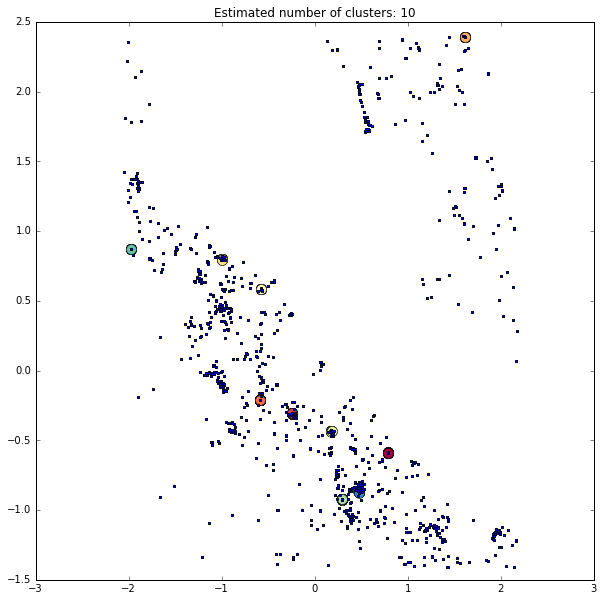

In [208]:
# Compute DBSCAN
db = DBSCAN(eps=0.005,algorithm='auto',min_samples=40).fit(XY_scale_sub)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# # Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)# Plot result
plt.figure(figsize=(10,10))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = XY_scale_sub[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=10)

#     xy = XY_scale_sub[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=4)

    plt.plot(XY_scale_sub[:, 0], XY_scale_sub[:, 1], 'o', markerfacecolor=None,
             markeredgecolor='k', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


# GMM

Estimated number of clusters: 15
[ 2  8  7 ..., 12 12 12]


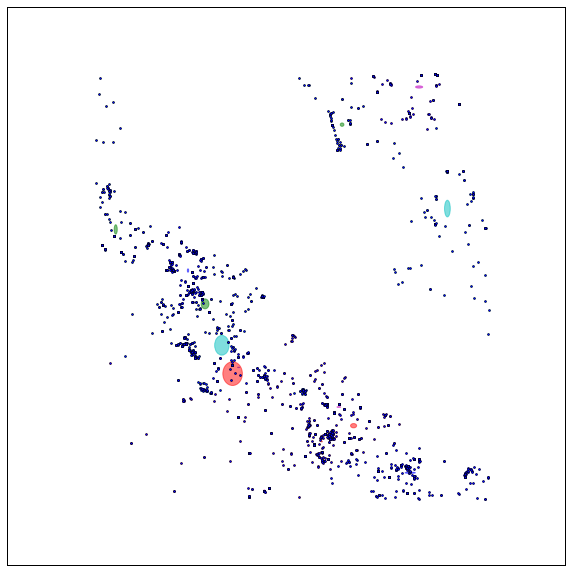

In [202]:
from sklearn import mixture
import itertools
from scipy import linalg
# Fit a Dirichlet process mixture of Gaussians using five components
plt.figure(figsize=(10,10))
plt.plot(XY_scale[:, 0], XY_scale[:, 1], 'o', markerfacecolor=None,
             markeredgecolor='k', markersize=2)

color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

dpgmm = mixture.GMM(n_components=15,n_iter=30)
dpgmm.fit(XY_scale_sub)
Y_ = dpgmm.predict(XY_scale_sub)
n_clusters_ = len(set(Y_)) - (1 if -1 in Y_ else 0)
print('Estimated number of clusters: %d' % n_clusters_)

print(Y_)
for i, (mean, covar, color) in enumerate(zip(
        dpgmm.means_, dpgmm._get_covars(), color_iter)):
    splot = plt.subplot(1, 1, 1)
    v, w = linalg.eigh(covar)
    u = w[0] / linalg.norm(w[0])
    # as the DP will not use every component it has access to
    # unless it needs it, we shouldn't plot the redundant
    # components.
    if not np.any(Y_ == i):
        continue
    plt.scatter(XY_scale[Y_ == i, 0], XY_scale[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())

plt.show()


In [ ]:
# initial centers
initial = [-122.2267666, 37.40926652] 

# Birch

n_clusters : 6


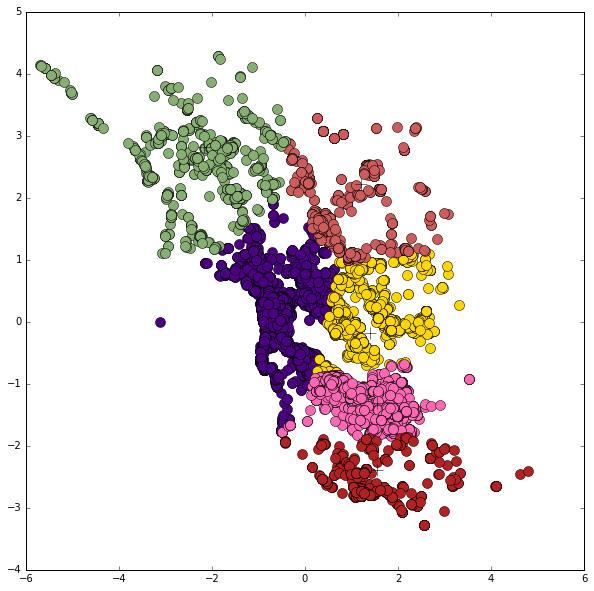

In [40]:
df = XY_scale
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, MiniBatchKMeans
from itertools import cycle
import matplotlib.colors as colors
birch_model = Birch(threshold=1.0, n_clusters=None)
birch_model.fit(df)
# Plot result
plt.figure(figsize=(10,10))
plt.plot(df[:, 0], df[:, 1], 'o', markerfacecolor=None,
             markeredgecolor='k', markersize=2)
labels = birch_model.labels_
centroids = birch_model.subcluster_centers_
n_clusters = np.unique(labels).size
print("n_clusters : %d" % n_clusters)

colors_ = cycle(colors.cnames.keys())
for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
    mask = labels == k
    plt.plot(df[mask, 0], df[mask, 1], 'o',
            markerfacecolor=col, markersize=10)
    if birch_model.n_clusters is None:
        plt.plot(this_centroid[0], this_centroid[1], '+', markerfacecolor=col,
                markeredgecolor='k', markersize=12)
plt.show()